In [1]:
# install Jupyter dependencies
# !pip install pandas seaborn biopython pyarrow wget tqdm

In [1]:
import pyarrow.parquet as pq
import pandas as pd
import ahocorasick
from Bio import SeqIO
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
tqdm.pandas()

The parquet files for the canonical peptides including the GCA proteins and GRCh38 can be downloaded from: 
http://ftp.pride.ebi.ac.uk/pub/databases/pride/resources/proteomes/proteogenomics/noncanonical-tissues-2023/PXD010154-1de73bcb-ee3e-4d19-9d8d-da72f11d5fac.psm.parquet 


In [2]:
import wget
import os
if not os.path.isfile('PXD010154-1de73bcb-ee3e-4d19-9d8d-da72f11d5fac.psm.parquet'):
   wget.download('http://ftp.pride.ebi.ac.uk/pub/databases/pride/resources/proteomes/proteogenomics/noncanonical-tissues-2023/PXD010154-1de73bcb-ee3e-4d19-9d8d-da72f11d5fac.psm.parquet')
parq_file = "PXD010154-1de73bcb-ee3e-4d19-9d8d-da72f11d5fac.psm.parquet"
table = pq.read_table(parq_file)
original_df = table.to_pandas()

In [3]:
print('Number of PSMs in the file = ', len(original_df))

Number of PSMs in the file =  16294599


In [11]:
## Add sample accessions, **NOTE it will work only for LFQ experiments**
sdrf = pd.read_csv("PXD010154.sdrf.tsv", sep = "\t")
sdrf_total = sdrf
sdrf = sdrf[['source name', 'comment[data file]']]
sdrf.rename(columns={"comment[data file]": "reference_file_name", "source name": "sample_id"}, inplace=True)
sdrf['reference_file_name'] = sdrf['reference_file_name'].str.replace('.raw', '', regex=False)
#sdrf
list(sdrf_total['characteristics[organism part]'].unique())

['adrenal gland',
 'appendix',
 'bone marrow',
 'brain',
 'colon',
 'duodenum',
 'esophagus',
 'fallopian tube',
 'fat adipose tissue',
 'gallbladder',
 'heart',
 'kidney',
 'liver',
 'lung',
 'lymph node',
 'ovary',
 'pancreas',
 'pituitary hypophysis',
 'placenta',
 'prostate',
 'rectum',
 'salivary gland',
 'small intestine',
 'smooth muscle',
 'spleen',
 'stomach',
 'testis',
 'thyroid',
 'urinary bladder',
 'uterine endometrium']

In [6]:
#Convert array values in the accession to list
def join_vals(x):
    return ','.join(x.astype(str).tolist())

original_df['protein_accessions'] = original_df['protein_accessions'].apply(join_vals)

#### Blast GCA with canonical

In this step, we need to take all the PSMs from the search and blast them against canonical databases including ENSEMBL protein database and Uniprot proteomes. This step is important because some non-canonical peptides may be identified in the GCA proteins but they also are found in reference databases. 


In [7]:
#Download the reference databases.
import gzip, shutil

ensembl_db = "https://ftp.ensembl.org/pub/release-110/fasta/homo_sapiens/pep/Homo_sapiens.GRCh38.pep.all.fa.gz"
if not os.path.isfile("Homo_sapiens.GRCh38.pep.all.fa"):
   wget.download(ensembl_db)
   with gzip.open("Homo_sapiens.GRCh38.pep.all.fa.gz", 'r') as f_in, open('Homo_sapiens.GRCh38.pep.all.fa', 'wb') as f_out:
      shutil.copyfileobj(f_in, f_out)

uniprot_db = "https://ftp.uniprot.org/pub/databases/uniprot/knowledgebase/reference_proteomes/Eukaryota/UP000005640/UP000005640_9606_additional.fasta.gz"
if not os.path.isfile("UP000005640_9606_additional.fasta"):
   wget.download(uniprot_db)
   with gzip.open("UP000005640_9606_additional.fasta.gz", 'r') as f_in, open('UP000005640_9606_additional.fasta', 'wb') as f_out:
      shutil.copyfileobj(f_in, f_out)


In [8]:
fa_set = set()
for j in SeqIO.parse("Homo_sapiens.GRCh38.pep.all.fa", "fasta"):
    fa_set.add(str(j.seq))
for j in SeqIO.parse("UP000005640_9606_additional.fasta", "fasta"):
    fa_set.add(str(j.seq))

In [9]:
def blast_with_canonical_fasta(peptide):
    for fasta in fa_set:
        if peptide in fasta:
            return "GRCh38"
    return "GCA"

In [10]:
start_time = datetime.datetime.now()
print(start_time)

seq_set = set(original_df["sequence"].to_list())

auto = ahocorasick.Automaton()
seq_dict = dict()
for seq_peptide in seq_set:
    auto.add_word(seq_peptide, seq_peptide)
    seq_dict[seq_peptide] = "GCA"

auto.make_automaton()

for protein_seq in tqdm(fa_set):
    for end_ind, found in auto.iter(protein_seq):
        seq_dict[found]= "GRCh38"

end_time = datetime.datetime.now()
print("End time :", end_time)
set_time_taken = end_time - start_time
print("Time consumption :", set_time_taken)

print("GCA: {}".format(sum(1 for v in seq_dict.values() if v == "GCA")))
print("GRCh38: {}".format(sum(1 for v in seq_dict.values() if v == "GRCh38")))


2024-04-23 06:25:15.636385


100%|██████████| 103747/103747 [00:04<00:00, 23557.33it/s]

End time : 2024-04-23 06:25:22.449921
Time consumption : 0:00:06.813536
GCA: 92621
GRCh38: 416219


In [11]:
#shorten accessions to save memory
def get_source(accessions):
    accessions = accessions.split(',')

    for acc in accessions:
        if acc.startswith('DECOY_CONTAMINANT'):
            return 'DECOY_CONTAMINANT'
    for acc in accessions:
        if acc.startswith('CONTAMINANT'):
            return 'CONTAMINANT'
    
    for acc in accessions:
        if acc.startswith('DECOY_GRCh38'):
            return 'DECOY_GRCh38'
    
    for acc in accessions:
        if acc.startswith('DECOY_GCA'):
            return 'DECOY_GCA'

    for acc in accessions:
        if acc.startswith('GRCh38'):
            return 'GRCh38'
    
    for acc in accessions:
        if acc.startswith('GCA'):
            return 'GCA'
    
    return accessions

In [12]:
original_df['prot_source'] = original_df['protein_accessions'].progress_apply(get_source)

100%|██████████| 16294599/16294599 [00:23<00:00, 684726.94it/s]


In [13]:
original_df['prot_source'] = original_df.progress_apply(lambda x: seq_dict.get(x['sequence']) if x['prot_source'] == 'GCA' else x['prot_source'], axis=1)

100%|██████████| 16294599/16294599 [02:41<00:00, 101035.52it/s]


In [14]:
original_df['prot_source'].value_counts()

GRCh38               15353327
CONTAMINANT            606683
GCA                    173255
DECOY_GCA              107166
DECOY_GRCh38            53107
DECOY_CONTAMINANT        1061
Name: prot_source, dtype: int64

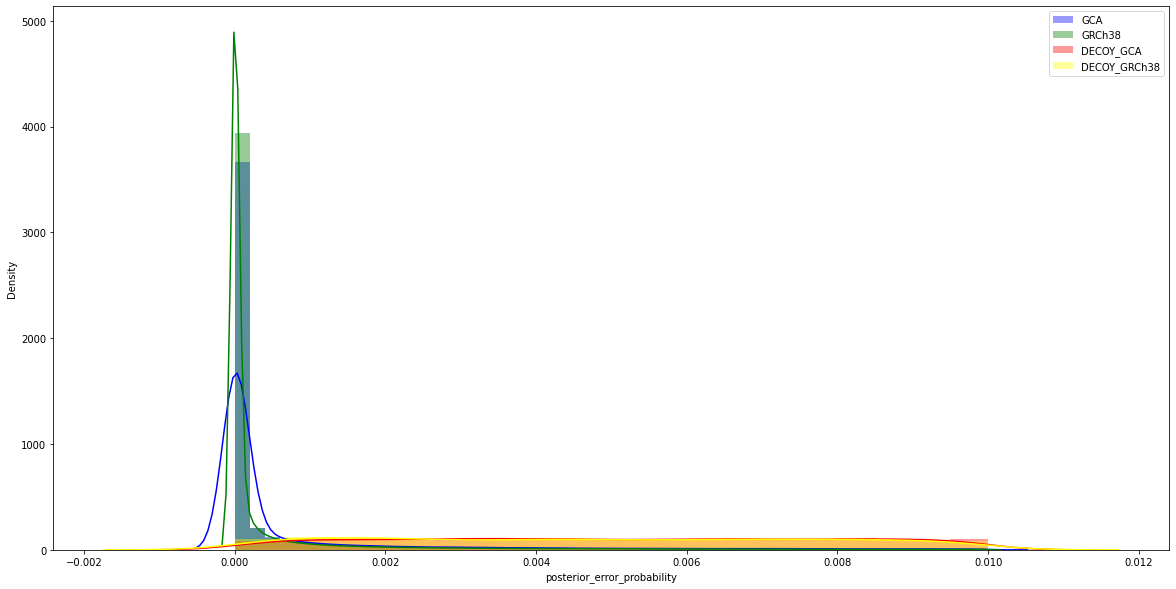

In [15]:
df2 = original_df[original_df['posterior_error_probability']<0.01]

gca = df2.loc[df2.prot_source.str.startswith("GCA")==True]
grch = df2.loc[df2.prot_source.str.startswith("GRCh38")==True]
decoy_grch = df2.loc[df2.prot_source.str.startswith("DECOY_GRCh38")==True]
decoy_gca = df2.loc[df2.prot_source.str.startswith("DECOY_GCA")==True]

#sns.df['posterior_error_probability']

plt.figure(figsize=(20, 10))
sns.distplot(gca['posterior_error_probability'], 
             hist=True, kde=True, label='GCA', color='blue')
sns.distplot(grch['posterior_error_probability'], 
             hist=True, kde=True, label='GRCh38', color='green')
sns.distplot(decoy_gca['posterior_error_probability'], 
             hist=True, kde=True, label='DECOY_GCA', color='red')
sns.distplot(decoy_grch['posterior_error_probability'], 
             hist=True, kde=True, label='DECOY_GRCh38', color='yellow')

plt.legend()

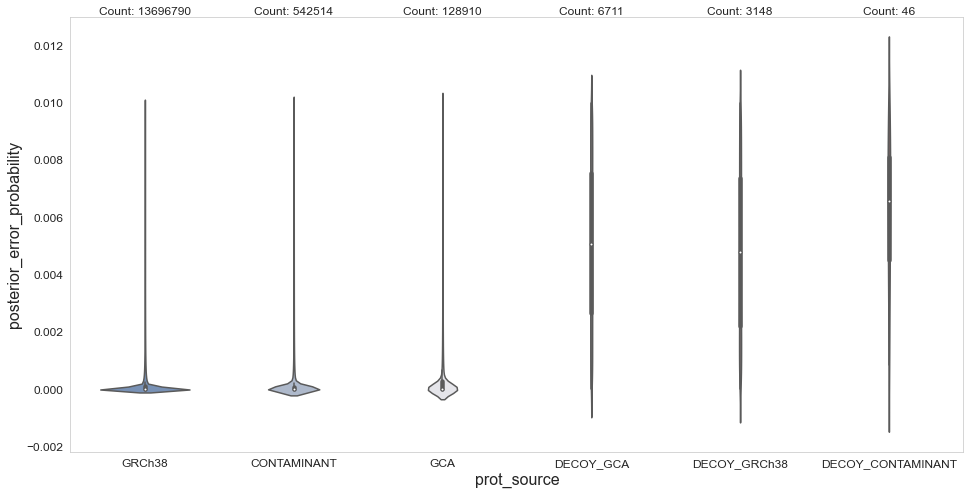

In [16]:
plt.figure(figsize=(16, 8))

sns.set_style("whitegrid")

sns.violinplot(
    data=df2, x="prot_source", y="posterior_error_probability", fill="prot_source",
    width=.6, palette="vlag"
)

count_data = df2["prot_source"].value_counts()
for idx, count in enumerate(count_data):
    plt.text(idx, df2["posterior_error_probability"].max() + 0.003, f'Count: {count}', 
             ha='center', va='bottom', fontsize=12) 

plt.xticks(rotation=0, fontsize=12)  
plt.xlabel("prot_source", fontsize=16)  
plt.ylabel("posterior_error_probability", fontsize=16)  
plt.yticks(fontsize=14)  
plt.tick_params(axis='both', which='both', labelsize=12) 
plt.grid(False) 
plt.savefig("plots/quantms-scores-plots/pep_violin_distributions.svg", format="svg")
plt.show()

In [17]:
original_df[original_df['posterior_error_probability']<0.01]['prot_source'].value_counts()

GRCh38               13696790
CONTAMINANT            542514
GCA                    128910
DECOY_GCA                6711
DECOY_GRCh38             3148
DECOY_CONTAMINANT          46
Name: prot_source, dtype: int64

In [18]:
print('Number of unique peptide sequences from\n GCA: {}\n canonical: {}'.format(len(gca.sequence.unique()), len(grch.sequence.unique())))
print('union', len(set(grch.sequence).union(set(gca.sequence))))
print('intesect', len(set(grch.sequence).intersection(set(gca.sequence))))

Number of unique peptide sequences from
 GCA: 7142
 canonical: 340914
union 348056
intesect 0


In [19]:
def rep(x):
    return re.sub('{[^}]*}', '', x.replace('(','{').replace(')', '}').replace('.',''))

gca_seqs = list(set([rep(x) for x in gca['sequence'].tolist()]))

len(gca_seqs)

7142

#### To DeepLC

In [20]:
mod_rep = {"UNIMOD:4":"Carbamidomethyl","UNIMOD:7":"Deamidated","UNIMOD:35":"Oxidation","UNIMOD:1":"Acetyl"}
def replace_mod(x):
    s = ""
    for mod in x:
        nums = mod.split("-")[0]
        m = mod.split("-")[1]
        for n in nums.split("|"):
            if s:
                s += "|"
            s += n + "|" + mod_rep.get(m)
    return s

# convert modifications and add the rt and sequence fields
gca.loc[:,"seq"] = gca.apply(lambda x : x["sequence"],axis = 1)
gca.loc[:,"modifications"] = gca.apply(lambda x : replace_mod(x["modifications"]) if x["modifications"] is not None else "", axis = 1)
gca.loc[:,"tr"] = gca.apply(lambda x : x["retention_time"],axis = 1)

grch.loc[:,"seq"] = grch.apply(lambda x : x["sequence"],axis = 1)
grch.loc[:,"modifications"] = grch.apply(lambda x : replace_mod(x["modifications"]) if x["modifications"] is not None else "", axis = 1)
grch.loc[:,"tr"] = grch.apply(lambda x : x["retention_time"],axis = 1)

#### Redundancy removal

In [21]:
def extract_keys_values(id_scores):
    # Split each pair by colon and create a dictionary
    key_value_dict = {}
    for kv in id_scores:
       if kv is None:
          print("The score is None")
       else:
          score_string = kv.split(":")
          if len(score_string) == 2:
            key_value_dict[score_string[0]] = score_string[1]
          elif len(score_string) > 2:
            key_value_dict[":".join(score_string[:-1])] = score_string[-1]
          else:
            print.warning("The score is not in the right format score: value")
    return pd.Series(key_value_dict)  

In [22]:
# Apply the function to create new columns
sdrf_dic = sdrf.set_index('reference_file_name').to_dict()['sample_id']

In [ ]:
new_columns = grch.progress_apply(lambda x: extract_keys_values(x["id_scores"]), axis=1)

# Concatenate the new columns with the original DataFrame
grch_deeplc = pd.concat([grch[['seq', 'tr', 'modifications', 'reference_file_name','sequence','protein_accessions','charge','scan_number','peptidoform', 'posterior_error_probability']], new_columns], axis=1)
grch_deeplc = pd.merge(grch_deeplc, sdrf, on=['reference_file_name'], how='left')
grch_deeplc['posterior_error_probability'] = grch_deeplc['posterior_error_probability'].astype(float)
grch_deeplc.sort_values('posterior_error_probability', inplace=True)
project = "PXD010154"
grch_deeplc["usi"] = "mzspec:" + project + ":" + grch_deeplc["reference_file_name"] + ":scan:" + grch_deeplc["scan_number"].astype(str) + ":" + grch_deeplc["peptidoform"] + "/" + grch_deeplc["charge"].astype(str)

100%|██████████| 13696790/13696790 [42:04<00:00, 11827.80it/s] 

In [ ]:
new_columns = gca.apply(lambda x: extract_keys_values(x["id_scores"]), axis=1)
# Concatenate the new columns with the original DataFrame
gca_deeplc = pd.concat([gca[['seq', 'tr', 'modifications', 'reference_file_name','sequence','protein_accessions','charge','scan_number','peptidoform', 'posterior_error_probability']], new_columns], axis=1)
gca_deeplc = pd.merge(gca_deeplc, sdrf, on=['reference_file_name'], how='left')
gca_deeplc['posterior_error_probability'] = gca_deeplc['posterior_error_probability'].astype(float)
gca_deeplc.sort_values('posterior_error_probability', inplace=True)
project = "PXD010154"
gca_deeplc["usi"] = "mzspec:" + project + ":" + gca_deeplc["reference_file_name"] + ":scan:" + gca_deeplc["scan_number"].astype(str) + ":" + gca_deeplc['peptidoform'] + "/" + gca_deeplc["charge"].astype(str)
gca_deeplc

#### Final save

In [ ]:
gca_deeplc.to_csv('tables/to-ms2pip-snr-tables/gca_peptides_for_deeplc.csv.gz', index=False, compression="gzip")
grch_deeplc.to_csv('tables/to-ms2pip-snr-tables/grch_peptides_for_deeplc.csv.gz', index=False, compression="gzip")

**Remove Redundancy**

In [ ]:
# grch_deeplc = grch_deeplc.drop_duplicates(["seq", "modifications"], keep="first")
# gca_deeplc = gca_deeplc.drop_duplicates(["seq", "modifications"], keep="first")

# gca_deeplc.to_csv('tables/to-ms2pip-snr-tables/gca_peptides_for_deeplc_unique.csv.gz', index=False, compression="gzip")
# grch_deeplc.to_csv('tables/to-ms2pip-snr-tables/grch_peptides_for_deeplc_unique.csv.gz', index=False, compression="gzip")